In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [0]:
fashion_mnist = keras.datasets.fashion_mnist

In [0]:
#!pip install tensorflow-gpu=='2.0.0rc2'

In [0]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

In [0]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /=255
test_images /=255

In [0]:
train_images.shape

(60000, 28, 28)

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def Generator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(256,activation='relu',input_shape = (100,)))
  model.add(tf.keras.layers.Dense(784,activation='tanh'))
  assert model.output_shape==(None,784)
  return model

In [0]:
generator = Generator()

In [0]:
noise = np.random.uniform(-1,1,size=[1,100])
noise
img = generator(noise)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [0]:
generator.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_72 (Dense)             (None, 784)               201488    
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


In [0]:
#plt.imshow(tf.reshape(img,(28,28)),cmap='gray')
img = np.reshape(img,(28,28))

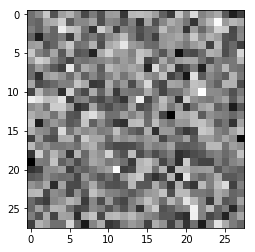

In [0]:
plt.imshow(img,cmap='gray')

In [0]:
def Discriminator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
  model.add(tf.keras.layers.Dense(256,activation='relu'))
  model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
  return model

In [0]:
discriminator = Discriminator()

In [0]:
#discriminator(img)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [0]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(predictions.shape)
  fig = plt.figure(figsize=(5,5))
  
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(np.reshape(predictions[ i, :],(28,28)) * 255,cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

(25, 784)


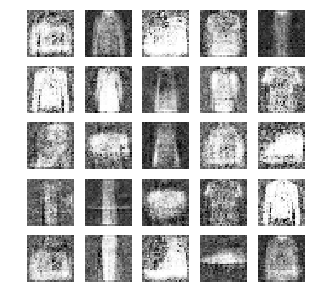

In [0]:
import time
from IPython import display
train(train_dataset, EPOCHS)

In [0]:
import imageio
import glob
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)